## Travel Agent

AI Travel Agent & Expense Planner(Purpose: Trip planning for any city worldwide with Realtime data.")

• Real-time weather information
• Top attractions and activities
• Hotel cost calculation (per day × total days)
• Currency conversion to user's native currency
• Complete itinerary generation
• Total expense calculation
• generate a summary of the entire output

user_input

search attraction and activity
1. search attracation
2. search restaurant
3. search activity
4. search transportation


search weather forcasting
1. get current weather
2. get weather forcast


search hotel costs
1. search hotel
2. estimate the hotel cost
3. budget_range


calculate total cost
1. add
2. multiply
3. calculated total cost
4. calcualte the daily budget
  

currency_converion
1. get exchnage rate
2. convert currancy
  

Itinery generation
1. get day plan
2. crete full itinery


create Trip Summary
  

Retun complete traval plan


In [53]:
import os
from dotenv import load_dotenv
load_dotenv()
import operator
from typing import Annotated, Sequence, List
from pydantic import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.tools import tool
import requests

In [2]:
## openai chat model
llm_openai = ChatOpenAI(model='o3-mini')

In [3]:
llm_openai.invoke('Hi')

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 7, 'total_tokens': 94, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o3-mini-2025-01-31', 'system_fingerprint': 'fp_e20469f047', 'id': 'chatcmpl-BjLG3Df3B0a0JmeZKdyWbjLkPVgSP', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--802a0815-0ac5-40e3-92e7-ce69c6acefc9-0', usage_metadata={'input_tokens': 7, 'output_tokens': 87, 'total_tokens': 94, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 64}})

In [68]:
from langchain_community.tools import DuckDuckGoSearchResults, DuckDuckGoSearchRun
from langchain_community.utilities import OpenWeatherMapAPIWrapper

In [24]:
import time
def get_search_results(user_query: str) -> str:
    '''
    This tool will use DuckDuckGo to search for 
    tourist attractions, restaurants, activities, and transportation based on user query.
    
    Args:
        user_query (str): The user's query for searching tourist attractions, restaurants, activities, and transportation.
        
    Returns:
        str: A string containing the search results formatted as a list of tourist attractions, restaurants, activities, and transportation options.
    '''
    search = DuckDuckGoSearchRun()
    
    queries = {
        "Attractions": 'Top 3 tourist attraction in {user_query}',
        "Restaurants": 'Top 3 restaurants in {user_query}',
        "Activities": 'Top 3 activities in {user_query}',
        "Transport" : 'Means of transport in {user_query}'
    }
    results = {}
    
    for key, query in queries.items():
        try:
            results[key] = search.invoke(query)
            time.sleep(5)
        except Exception as e:
            print(f'Error {str(e)}')
        
    return results


In [28]:
get_search_results('Paris, France')

{'Attractions': 'Around 3.8 million people visit every year, making it Austria\'s top tourist spot. Walk through grand rooms once used by emperors. The palace oozes royal history—golden halls, manicured gardens, and classic art everywhere you look. The park around the palace is massive. There\'s even a zoo and some gorgeous fountains. Visitors have decided These are the 9 best museums in Germany New top ranking The 10 best ice cream parlors in Germany According to "Time Out" Hong Kong Is the City with the Best Public Transporta in the World 3rd place: Angkor Wat, Cambodia. The Angkor Wat temple complex in Siem Reap, Cambodia, ranks third in Tripadvisor\'s rankings of the world\'s most popular attractions. Global tourism weaves together history, culture, and modern entertainment in ways that captivate millions each year. In this guide, we reveal 21 of the most visited tourist attractions in the world, spanning massive malls, ancient wonders, bustling city squares, and legendary theme pa

In [92]:
import time
@tool 
def search_result(query:str) -> str:
    '''
    Search results using DuckDuckGoSearch
    
    Args:
        query (str): The user's query for searching tourist attractions, restaurants, activities, and transportation.
        
    Returns:
        str: A string containing the search results formatted as a list of tourist attractions, restaurants, activities, and transportation options.
    '''
    
    search = DuckDuckGoSearchRun()
    result = search.invoke(query)
    return(f'ToolCall : {result}')
    time.sleep(5)
    
    return result

In [98]:
from langchain_community.tools.tavily_search import TavilySearchResults
#search = DuckDuckGoSearchRun()
weather = OpenWeatherMapAPIWrapper()
tavily_tool = TavilySearchResults(max_results=3)
llm_openai = ChatOpenAI(model='o3-mini')
llm_with_tool = llm_openai.bind_tools([tavily_tool, weather.run])

In [ ]:
SYSTEM_PROMPT = SystemMessage(
    content = '''You are a helpful travel agent and your task is to find following information in a city based on user queries:
        Use TavilyTool Search to find:
        1. top 2 tourist attractions
        2. top 2 restaurants
        3. top 2 activities 
        4. means of transportation for the city mentioned in user query
        
        Use OpenWeatherMap to find (if travel date is provided use that else user current date):
        5. current weather and weather forcast for the city mentioned in user query.
        '''
)

def function_tool(state:MessagesState):
    
    user_question = state['messages']
    
    input_question = [SYSTEM_PROMPT] + user_question
    
    response = llm_with_tool.invoke(input_question)
    print(response)
    
    return {'messages': [response]}

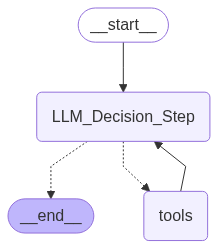

In [103]:
import sys
builder = StateGraph(MessagesState)
builder.add_node('LLM_Decision_Step',function_tool)
builder.add_node('tools', ToolNode([tavily_tool, weather.run]))
builder.add_edge(START,'LLM_Decision_Step')
builder.add_conditional_edges(
    'LLM_Decision_Step',
    tools_condition
)
builder.add_edge('tools','LLM_Decision_Step')
app = builder.compile()
app

In [104]:
message = [HumanMessage(content = 'Kelowna, Canada')]
app.invoke({'messages':message})

content='' additional_kwargs={'tool_calls': [{'id': 'call_DvGHGRpSAgfSxf6ToTxCizVF', 'function': {'arguments': '{"query": "Kelowna, Canada top 2 tourist attractions"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 810, 'prompt_tokens': 235, 'total_tokens': 1045, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 768, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o3-mini-2025-01-31', 'system_fingerprint': 'fp_e20469f047', 'id': 'chatcmpl-BjM9h5DPCeU0UbDIaAo1zw5fqwVPb', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--5eda6755-6e1c-453b-a8fd-a852ed4a9bda-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Kelowna, Canada top 2 tourist attractions'}, 'id': 'call_DvGHGRpSAgfSxf6ToTxCizVF', 'type': 'tool_call'}] usage_metadata={

{'messages': [HumanMessage(content='Kelowna, Canada', additional_kwargs={}, response_metadata={}, id='f1275690-1e36-4e4a-828c-f97201527ee6'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DvGHGRpSAgfSxf6ToTxCizVF', 'function': {'arguments': '{"query": "Kelowna, Canada top 2 tourist attractions"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 810, 'prompt_tokens': 235, 'total_tokens': 1045, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 768, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o3-mini-2025-01-31', 'system_fingerprint': 'fp_e20469f047', 'id': 'chatcmpl-BjM9h5DPCeU0UbDIaAo1zw5fqwVPb', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5eda6755-6e1c-453b-a8fd-a852ed4a9bda-0', tool_calls=[{'name': 'tavily_searc

In [30]:
for msg in response['messages']:
    msg.pretty_print()

================================ Human Message =================================

Kelowna, Canada
================================== Ai Message ==================================
Tool Calls:
  search_result (call_HM4kWJ8liJUXalEkXtZ9Tmo4)
 Call ID: call_HM4kWJ8liJUXalEkXtZ9Tmo4
  Args:
    state: {'messages': [{'content': 'Please provide detailed travel recommendations for Kelowna, Canada. I am looking for the top 5 tourist attractions, top 5 restaurants, top 5 activities, and the common means of transportation within the city. Please include any useful details about each category to help plan a trip.'}]}
================================= Tool Message =================================
Name: search_result

Error: search_result is not a valid tool, try one of [duckduckgo_search, run].
================================== Ai Message ==================================
Tool Calls:
  run (call_s57YrvDspl6zdQNZHcEKKLj9)
 Call ID: call_s57YrvDspl6zdQNZHcEKKLj9
  Args:
    location: Kelowna, Cana

In [20]:
response

{'messages': [HumanMessage(content='Prepare a travel plan for Kelowna, Canada from 1-4 July 2025', additional_kwargs={}, response_metadata={}, id='8f6cf1b5-546d-4125-b482-c8aa0a86218d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_beEIoI7HoVdsBF0ZI5UuInXB', 'function': {'arguments': '{"query": "Kelowna top 5 tourist attractions in Kelowna, Canada"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 813, 'prompt_tokens': 238, 'total_tokens': 1051, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 768, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o3-mini-2025-01-31', 'system_fingerprint': 'fp_e20469f047', 'id': 'chatcmpl-BjLMwwqF0TP5LxFAGsgMV7LWsmtFY', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--61bc244f-79ba-4eac-ab0e-ef34

In [81]:
from langchain_community.utilities import GoogleSerperAPIWrapper, GooglePlacesAPIWrapper
from langchain_community.tools import  DuckDuckGoSearchRun
search_google_serp = GoogleSerperAPIWrapper()
search_duckduck = DuckDuckGoSearchRun()


In [ ]:
search_duckduck.invoke('Best 3 hotels in Kelowna, canada')

"Super 8 by Wyndham West Kelowna BC Hotel | Best Affordable Hotel in West Kelowna This modern hotel in Kelowna provides complimentary Wi-Fi, a Jacuzzi and an indoor pool. It is a 10-minute drive from Quails' Gate Winery and offers free parking on site. This blog may contain affiliate links. Read our disclosure policy for more info. Kelowna is the gateway to the stunning Okanagan Valley, an area famed for its natural landscapes, hiking and biking trails, ski resorts (Big White is the big one here), and wineries.It's the largest city in the region and is on the edge of Okanagan Lake. Business Meets Pleasure: Kelowna's Best Hotels for Business Travellers. Blending the brisk efficiency of business with the leisurely pace of pleasure, Kelowna emerges as a prime spot for business travellers. ... 5505 Airport Way, Kelowna, BC V1V 3C3 Canada. Holiday Inn Express & Suites Kelowna - East. 1620 Powick Rd, Kelowna, BC V1X 7G5 Canada. Whether you're planning a weekend getaway, a business trip, or a

In [ ]:
import pprint
result = search_google_serp.run('hotels in Kelowna in total budget of $150 for 2 nights')
pprint.pp(result)

('Are you on a budget? With Expedia, book now and pay later on most Cheap '
 'Kelowna Hotels! Browse our selection of 33 cheap hotels in Kelowna and save '
 'money on ... Missing: $150 | Show results with:$150. The 10 best hotels in '
 'Kelowna ; Casa Loma BnbRank #1. $168-$183/night. 2769 Benedick Road ; '
 'TownePlace Suites by Marriott West KelownaRank #2. $92-$404/night. Missing: '
 'total | Show results with:total. Top Kelowna Cheap Hotels · Hotel Zed '
 'Kelowna · Accent Inns Kelowna · Dilworth Inn · Recreation Inn & Suites · '
 'University of British Columbia - UBC Okanagan Campus. Missing: $150 | Show '
 'results with:$150. Search and compare 88 hotels in Kelowna for the best '
 'hotel deals at momondo. Find the cheapest prices for luxury, boutique, or '
 'budget hotels in Kelowna. Missing: total budget $150. To make the most of '
 "your time in Kelowna, book a hotel that's right for you. We've collected "
 "some of the city's hottest hotels, from luxury to budget-friendly. Mis

### Check_Weather Class to get current weather forcast.

In [ ]:

class Check_Weather:
    def __init__(self,api_key: str):
        self.api_key = api_key
        self.base_url = 'https://api.openweathermap.org/data/2.5'
        
    def get_weather(self, city: str) -> str:
        ''' Get the current weather for a given city.'''
        try:
            self.url = f'{self.base_url}/weather?q={city}&units=metric&appid={self.api_key}'
            response = requests.get(self.url)
            return response.json()
        except Exception as e:
            print(f'Error: {str(e)}')
            return {}
        
    def get_forecast(self, city: str) -> str:
        ''' Get the weather forecast for a given city.'''
        try:
            days = 8
            self.url = f'{self.base_url}/forecast?q={city}&cnt={days}&units=metric&appid={self.api_key}'
            print(self.url)
            response = requests.get(self.url)
            return response.json()
        except Exception as e:
            print(f'Error: {str(e)}')
            return {}
    

In [50]:
weather_api_key = os.getenv('OPENWEATHERMAP_API_KEY')
weather = Check_Weather(api_key = weather_api_key)


In [51]:
result = weather.get_weather('Kelowna, Canada')
result

{'coord': {'lon': -119.4857, 'lat': 49.8831},
 'weather': [{'id': 800,
   'main': 'Clear',
   'description': 'clear sky',
   'icon': '01n'}],
 'base': 'stations',
 'main': {'temp': 19.49,
  'feels_like': 18.46,
  'temp_min': 19.49,
  'temp_max': 19.49,
  'pressure': 1012,
  'humidity': 37,
  'sea_level': 1012,
  'grnd_level': 903},
 'visibility': 10000,
 'wind': {'speed': 2.06, 'deg': 80},
 'clouds': {'all': 0},
 'dt': 1750229102,
 'sys': {'type': 1,
  'id': 852,
  'country': 'CA',
  'sunrise': 1750160927,
  'sunset': 1750219748},
 'timezone': -25200,
 'id': 5990579,
 'name': 'Kelowna',
 'cod': 200}

In [52]:
weather.get_forecast('Kelowna')

https://api.openweathermap.org/data/2.5/forecast?q=Kelowna&cnt=8&units=metric&appid=b9b9faa2b26cbccb37d5a2d1561ffdc0


{'cod': '200',
 'message': 0,
 'cnt': 8,
 'list': [{'dt': 1750237200,
   'main': {'temp': 17.55,
    'feels_like': 16.51,
    'temp_min': 13.67,
    'temp_max': 17.55,
    'pressure': 1011,
    'sea_level': 1011,
    'grnd_level': 903,
    'humidity': 44,
    'temp_kf': 3.88},
   'weather': [{'id': 800,
     'main': 'Clear',
     'description': 'clear sky',
     'icon': '01n'}],
   'clouds': {'all': 1},
   'wind': {'speed': 0.36, 'deg': 196, 'gust': 0.83},
   'visibility': 10000,
   'pop': 0,
   'sys': {'pod': 'n'},
   'dt_txt': '2025-06-18 09:00:00'},
  {'dt': 1750248000,
   'main': {'temp': 14.64,
    'feels_like': 13.62,
    'temp_min': 12.22,
    'temp_max': 14.64,
    'pressure': 1012,
    'sea_level': 1012,
    'grnd_level': 904,
    'humidity': 56,
    'temp_kf': 2.42},
   'weather': [{'id': 800,
     'main': 'Clear',
     'description': 'clear sky',
     'icon': '01d'}],
   'clouds': {'all': 3},
   'wind': {'speed': 0.68, 'deg': 219, 'gust': 0.9},
   'visibility': 10000,
   'po

## Currency Convertion using https://frankfurter.dev/

In [66]:

class Currency_Converter:
    
    def __init__(self):
        self.base_url = 'https://api.frankfurter.dev/v1/latest'
        
    def convert_currency(self, from_currency: str, to_currency: str, amount:float) -> float:
        ''' Convert currency from one to another.'''
        try:
            url = f'{self.base_url}?amount={amount}&from={from_currency}&to={to_currency}'
            response = requests.get(url)
            result = response.json()
            return result['rates']
        except Exception as e:
            print(f'Error: {str(e)}')
            return None
        

In [67]:
converter = Currency_Converter()
converter.convert_currency('CAD','INR', 500)

{'INR': 31801}

## Calculator for expense calculations

In [82]:
class Calculator:
    
    @staticmethod
    def add(a: float, b:float) -> float:
        '''
        Add two numbers.
        
        Args:
            a (float): First number.
            b (float): Second number.
        Returns:
            float: Sum of a and b.
        '''
        return a + b
    
    @staticmethod
    def multiply(a: float, b:float) -> float:
        '''
        Multiply two numbers.
        
        Args:
            a (float): First number.
            b (float): Second number.
        Returns:
            float: Product of a and b.
        '''
        return a * b
    
    @staticmethod 
    def calculate_total_cost(*costs: float) -> float:
        '''
        Calculate the total cost from a list of costs.
        
        Args:
            *costs (float): List of costs to be summed up.
        Returns:
            float: Total cost.
        '''
        return sum(costs)
    
    @staticmethod
    def calculate_daily_budget(total_cost: float, days: int) -> float:
        '''
        Calculate the daily budget based on total cost and number of days.
        Args:
            total_cost (float): Total cost of the trip.
            days (int): Number of days for the trip.
        Returns:
            float: Daily budget for the trip.
        '''
        return total_cost / days if days > 0 else 0
    

In [ ]:
sum